# Testing the effects of different datasets on redshifts

In this notebook, we will provide examples of how to create datasets with various different degradations applied, and test out the effects of these degradations on the resulting estimated photometric redshifts. 

In [1]:
import rail.interactive as ri 
import numpy as np
import tables_io
from pzflow.examples import get_galaxy_data

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


LEPHAREDIR is being set to the default cache directory:
/home/jscora/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/jscora/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/jscora/.cache/lephare/runs/20250327T165906


In [2]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}

In [3]:
catalog = get_galaxy_data().rename(band_dict, axis=1)

In [ ]:
flow_model = ri.creation.engines.flowEngine.flow_modeler(
    input=catalog,
    seed=0,
    phys_cols={"redshift": [0, 3]},
    phot_cols={
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    calc_colors={"ref_column_name": "mag_i_lsst"},
)

# get sample test and training data sets
train_data_orig = ri.creation.engines.flowEngine.flow_creator(
    n_samples=600, model=flow_model["model"], seed=1235
)
test_data_orig = ri.creation.engines.flowEngine.flow_creator(
    model=flow_model["model"], n_samples=600, seed=1234
)

Inserting handle into data store.  input: None, FlowModeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 3.9686
(2) 1.9351
(3) 5.2006
(4) -0.3579
(5) 2.2561
(6) 1.5917
(7) 0.3691
(8) -1.0218
(9) inf
Training stopping after epoch 9 because training loss diverged.
Inserting handle into data store.  model: inprogress_model.pkl, FlowModeler
Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x76fe85dcf5f0>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator
Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x76fe85dcf5f0>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


## Degradation

Let's make 3 different training data sets using increasingly more degraders. Then we'll train an estimator with each of the different data sets, and use the same test data (with all the degradations) to get the redshifts, and compare the results. 

**[NEEDS EDITING]** 
If we instead want to ensure that our sample remains the same size -- which will be important later for evaluating the results, since we need to have the true redshift and the estimated redshift to compare -- we can pass in `drop_rows=False` to the degrader. We'll do this for our test data sample, so we can use this degrader but keep the same number of samples. 

In [ ]:
test_data_inc = ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(input=test_data_errs["output"], pivot_redshift=1.0, drop_rows=False) # have drop_rows = False so we can keep our test sample the same size
test_data_inc["output"].info() # look at the output 
test_data_inc["output"][test_data_inc["output"]["flag"]] # mask the data down to cut out the lines that are cut out by the degrader 

In [14]:
### create three different training data sets
n_final = 400

# dataset 1: just photometric errors 
train_data_photerrs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)
# renames error columns to match DC2
train_data_photerrs_col = ri.tools.table_tools.column_mapper(
    input=train_data_photerrs["output"], columns=rename_dict
)
#converts output to a numpy dictionary
train_data = ri.tools.table_tools.table_converter(
    input=train_data_photerrs_col["output"], output_format="numpyDict"
)
df_train_photerrs = tables_io.convertObj(train_data_photerrs_col["output"], tables_io.types.PD_DATAFRAME)


# dataset 2: add in redshift incompleteness 
train_data_inc = (
    ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
        input=train_data_photerrs["output"], pivot_redshift=1.0
    )
)
# renames error columns to match DC2
train_data_inc_col = ri.tools.table_tools.column_mapper(
    input=train_data_inc["output"], columns=rename_dict
)
df_train_inc = tables_io.convertObj(train_data_inc_col["output"], tables_io.types.PD_DATAFRAME)


# dataset 3: add in line confusion
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)
# renames error columns to match DC2
train_data_conf_col = ri.tools.table_tools.column_mapper(
    input=train_data_conf["output"], columns=rename_dict
)
df_train_conf = tables_io.convertObj(train_data_conf_col["output"], tables_io.types.PD_DATAFRAME)


# cut all the dataframes down to be an equal size
df_train_photerrs = df_train_photerrs.iloc[:n_final]
df_train_inc = df_train_inc.iloc[:n_final]
df_train_conf = df_train_conf.iloc[:n_final]


Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, TableConverter
Inserting handle into data store.  output: inprogress_output.hdf5, TableConverter
Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, Co

In [ ]:
### degrade test data
# add photometric errors modelled on LSST to the data
test_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=test_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)
# randomly removes some galaxies above certain redshift threshold 
test_data_inc = (
    ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
        input=test_data_errs["output"], pivot_redshift=1.0
    )
)
# simulates the effect of misidentified lines 
test_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=test_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)
# # cut some of the data below a certain magnitude 
# test_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
#     input=test_data_conf["output"], cuts={"mag_i_lsst": 25.0}
# )
# renames error columns to match DC2
test_data_pq = ri.tools.table_tools.column_mapper(
    input=test_data_conf["output"], columns=rename_dict
)

df_test_data = tables_io.convertObj(test_data_pq["output"], tables_io.types.PD_DATAFRAME)


# # converts output to a numpy dictionary
# train_data = ri.tools.table_tools.table_converter(
#     input=train_data_pq["output"], output_format="numpyDict"
# )

Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness
Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper


### Plot the different datasets 

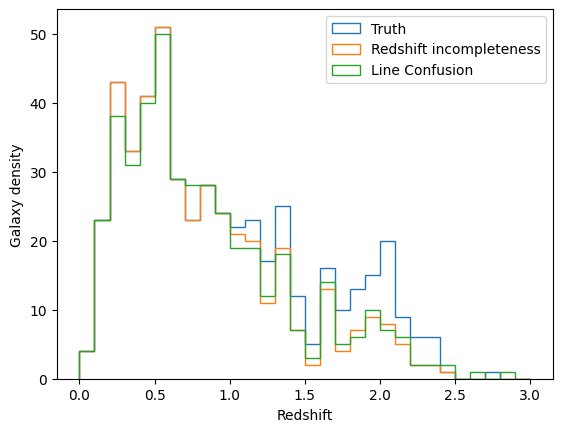

In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline

hist_options = {
    "histtype": "step",
    "bins":30,
    "range": (0,3)
}

plt.hist(df_train_photerrs["redshift"],label="Truth",**hist_options)
plt.hist(df_train_inc["redshift"], label="Redshift incompleteness",**hist_options)
plt.hist(df_train_conf["redshift"], label="Line Confusion",**hist_options)
plt.xlabel("Redshift")
plt.ylabel("Galaxy density")
plt.legend(loc="best")

In [8]:
# train the model
inform_bpz = ri.estimation.algos.bpz_lite.bpz_lite_informer(
    input=train_data, nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname=""
)
# estimate the photozs 
bpz_estimated = ri.estimation.algos.bpz_lite.bpz_lite_estimator(
input=df_test_data,
model=inform_bpz["model"],
nondetect_val=np.nan,
hdf5_groupname="",
)

bpz_estimated

Inserting handle into data store.  input: None, BPZliteInformer
Inserting handle into data store.  model: inprogress_bpz.pkl, BPZliteInformer
Inserting handle into data store.  input: None, BPZliteEstimator
Inserting handle into data store.  model: {'fo_arr': array([0.35, 0.5 ]), 'kt_arr': array([0.45 , 0.147]), 'zo_arr': array([0.431 , 0.39  , 0.0626]), 'km_arr': array([0.0913, 0.0636, 0.123 ]), 'a_arr': array([2.465, 1.806, 0.906]), 'mo': 20.0, 'nt_array': [1, 2, 5]}, BPZliteEstimator
Process 0 running estimator on chunk 0 - 429
Inserting handle into data store.  output: inprogress_output.hdf5, BPZliteEstimator


{'output': Ensemble(the_class=interp,shape=(429, 301))}

In [9]:
df_train_photerrs

,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.333901,24.491504,0.069380,24.851932,0.032505,25.027820,0.033317,25.262364,0.066999,25.314825,0.133419,25.866114,0.444376
1,0.730130,26.724103,0.447586,25.129026,0.041494,23.397917,0.009077,22.018731,0.006188,21.598201,0.006937,21.402925,0.010436
2,0.416053,25.971704,0.247038,25.807483,0.075632,24.947546,0.031043,24.937690,0.050229,25.258583,0.127081,25.417658,0.313460
3,0.571520,24.100994,0.049206,23.844136,0.013926,22.724945,0.006511,21.897095,0.005980,21.513569,0.006702,21.269130,0.009541
4,0.168161,24.828426,0.093230,23.717783,0.012642,23.251474,0.008317,23.265394,0.012131,22.822064,0.015209,22.714987,0.030329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.033198,NaN,NaN,27.764624,0.392245,27.759908,0.349317,26.929622,0.280000,NaN,NaN,28.111512,1.747148
496,1.975477,NaN,NaN,28.052365,0.487739,26.961091,0.181533,26.766743,0.245093,26.024208,0.243154,25.801805,0.423209
497,0.357116,27.872208,0.980687,26.837151,0.184688,25.967066,0.076586,25.775513,0.105292,25.492210,0.155418,25.606925,0.364072
498,1.365793,27.246182,0.653041,27.301904,0.271651,26.950035,0.179841,25.915059,0.118918,12.358987,0.005000,10.629788,0.005000


## Estimate

In [10]:
train_datasets = [df_train_photerrs, df_train_inc, df_train_conf]
point_est_list = []
eval_list = []

for df in train_datasets:

    # train the model
    inform_bpz = ri.estimation.algos.bpz_lite.bpz_lite_informer(
        input=df, nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname=""
    )
    # estimate the photozs 
    bpz_estimated = ri.estimation.algos.bpz_lite.bpz_lite_estimator(
    input=df_test_data,
    model=inform_bpz["model"],
    nondetect_val=np.nan,
    hdf5_groupname="",
    )

    # summarize the distributions
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=bpz_estimated["output"]
    )
    point_est_list.append(point_estimate_ens)

    # evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
        },
    )
    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": bpz_estimated["output"], "truth": test_data_orig["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    eval_list.append(the_eval)


Inserting handle into data store.  input: None, BPZliteInformer
Inserting handle into data store.  model: inprogress_bpz.pkl, BPZliteInformer
Inserting handle into data store.  input: None, BPZliteEstimator
Inserting handle into data store.  model: {'fo_arr': array([0.35, 0.5 ]), 'kt_arr': array([0.45 , 0.147]), 'zo_arr': array([0.431 , 0.39  , 0.0626]), 'km_arr': array([0.0913, 0.0636, 0.123 ]), 'a_arr': array([2.465, 1.806, 0.906]), 'mo': 20.0, 'nt_array': [1, 2, 5]}, BPZliteEstimator
Process 0 running estimator on chunk 0 - 429
Inserting handle into data store.  output: inprogress_output.hdf5, BPZliteEstimator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 429
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, DistToPointEvaluator
Insertin

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (429,) (500,) 